# **Data Engineering and Classical Machine Learning methods for Calssification**
# Ali Ebrahimi Feb 2020
---


The csv file has the following columns:

| column name | description |
|:-------------:|:-------------:|
| location_name | the location where the counter was installed |
| count      | number of bicycles passed by |
| max temp | maximum temperature (Celsius) |
| mean temp | average temperature (Celsius) |
| min temp | minimum temperature (Celsius) |
| snow on grnd (cm) | snow on ground |
| total precip (mm) | total precipitation |
| total rain (mm) | total rain |
| total snow (cm) | total snow |
| date | date of recording |


In this part we perform **data engineering**, **classical machine learning** methods to solve a multi-class classification problem.

# 1. Import and Clean the Dataset

In [0]:
import pandas as pd
import numpy as np
import sklearn
import scipy
import torch

In [0]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))

In [0]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [0]:
df

,location_name,count,max temp,mean temp,min temp,snow on grnd (cm),total precip (mm),total rain (mm),total snow (cm),date
0,ALEX,0,-14.0,-18.2,-22.3,27.0,0.3,0.0,0.3,2015-02-20
1,ADAWE BIKE,968,29.5,23.8,18.0,0.0,2.8,2.8,0.0,2016-08-28
2,COBY,10,-3.0,-9.3,-15.6,1.0,7.0,0.0,9.5,2011-12-25
3,SOMO,122,14.0,8.8,3.5,0.0,34.4,34.4,0.0,2017-05-01
4,OYNG,228,15.2,9.4,3.5,0.0,0.0,0.0,0.0,2015-04-27
...,...,...,...,...,...,...,...,...,...,...
23023,ALEX,495,11.0,6.5,2.0,0.0,0.0,0.0,0.0,2016-10-23
23024,OGLD,79,-1.0,-6.5,-12.0,17.0,0.8,0.0,0.4,2017-03-06
23025,OBVW,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-28
23026,OGLD,225,6.0,3.0,0.0,0.0,0.0,0.0,0.0,2016-04-12


In [0]:
draw_missing_data_table(df)

,Total,Percent
total snow (cm),120,0.005211
total rain (mm),120,0.005211
total precip (mm),120,0.005211
snow on grnd (cm),120,0.005211
min temp,106,0.004603
mean temp,106,0.004603
max temp,106,0.004603
date,0,0.000000
count,0,0.000000
location_name,0,0.000000


In [0]:
df.dropna(inplace=True)
draw_missing_data_table(df)

,Total,Percent
date,0,0.0
total snow (cm),0,0.0
total rain (mm),0,0.0
total precip (mm),0,0.0
snow on grnd (cm),0,0.0
min temp,0,0.0
mean temp,0,0.0
max temp,0,0.0
count,0,0.0
location_name,0,0.0


**Task objective:** given an input of `date, max temp, mean temp, min temp, snow on grnd (cm), total precip (mm), total rain (mm), total snow (cm)`, predict whether the tota
l number of bicycles observed in a day is ***less than 2000***, ***in between 2000 and 10k*** or ***over 10k***.

## 2. Pre-processing


1. First sum the counts at different locations in a day. In other words, you are creating a new `DataFrame` that contains the following columns:
    - `date`
    - `max temp`
    - `mean temp`
    - `min temp`
    - `snow on grnd (cm)`
    - `total precip (mm)`
    - `total rain (mm)`
    - `total snow (cm)`
    - `total count`
    

2. Convert the numerical column `total count` into three categories: *less than 2000*, *2000 to 10000* and *over 10000*. Save the `processed_df` to `processed_data.csv`.

In [0]:
processed_df = df.groupby(pd.to_datetime(df.date).dt.date).agg(
    ...:     {'count':'sum', 'location_name':'first', 'max temp':'max', 'mean temp':'mean', 'min temp':'min', 'snow on grnd (cm)':'max', 'total precip (mm)':'max',
              'total rain (mm)':'max', 'total snow (cm)':'max'}).reset_index() 

In [0]:
processed_df

,date,count,location_name,max temp,mean temp,min temp,snow on grnd (cm),total precip (mm),total rain (mm),total snow (cm)
0,2010-01-01,0,ORPY,-2.5,-4.1,-5.7,18.0,5.0,0.0,7.6
1,2010-01-02,0,ALEX,-11.9,-13.3,-14.6,21.0,1.9,0.0,2.6
2,2010-01-03,0,ORPY,-7.8,-11.4,-15.0,21.0,2.0,0.0,3.0
3,2010-01-04,0,COBY,-7.5,-9.0,-10.5,21.0,1.0,0.0,2.0
4,2010-01-05,0,COBY,-5.0,-7.8,-10.6,21.0,1.0,0.0,1.5
...,...,...,...,...,...,...,...,...,...,...
3255,2018-12-27,687,ADAWE PED,-4.0,-10.5,-17.0,5.0,3.0,0.0,2.0
3256,2018-12-28,97,LMET,6.5,-2.3,-11.0,5.0,8.8,8.0,1.0
3257,2018-12-29,723,ADAWE PED,-5.5,-7.8,-10.0,2.0,0.0,0.0,0.0
3258,2018-12-30,195,OBVW,-5.5,-9.5,-13.5,2.0,0.4,0.0,1.0


In [0]:
bins = [-1, 2000, 10000, np.inf]
names = [1, 2, 3]

processed_df['total count'] = pd.cut(processed_df['count'], bins, labels=names)
del processed_df['count']
print(processed_df.dtypes)

date                   object
location_name          object
max temp              float64
mean temp             float64
min temp              float64
snow on grnd (cm)     float64
total precip (mm)     float64
total rain (mm)       float64
total snow (cm)       float64
total count          category
dtype: object


In [0]:
processed_df.location_name = pd.factorize(processed_df.location_name)[0]
processed_df.date = pd.factorize(processed_df.date)[0]

print(processed_df.dtypes)

date                    int64
location_name           int64
max temp              float64
mean temp             float64
min temp              float64
snow on grnd (cm)     float64
total precip (mm)     float64
total rain (mm)       float64
total snow (cm)       float64
total count          category
dtype: object


## 3. Data engineering

Spliting the dataset into train set (80%) and test set (20%). 


In [0]:
X = processed_df.iloc[:, 0:-2]
y = processed_df.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)


##  4. Classical machine learning methods

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


 RF: 0.765358 (0.032277)


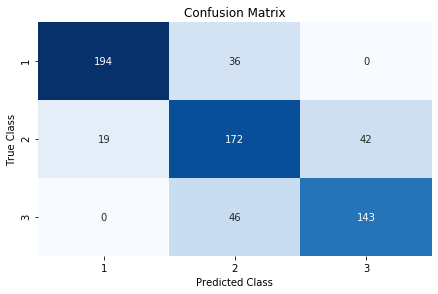

              precision    recall  f1-score   support

           1       0.91      0.84      0.88       230
           2       0.68      0.74      0.71       233
           3       0.77      0.76      0.76       189

    accuracy                           0.78       652
   macro avg       0.79      0.78      0.78       652
weighted avg       0.79      0.78      0.78       652

 KNN: 0.761522 (0.021875)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


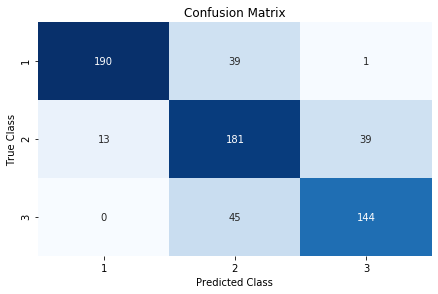

              precision    recall  f1-score   support

           1       0.94      0.83      0.88       230
           2       0.68      0.78      0.73       233
           3       0.78      0.76      0.77       189

    accuracy                           0.79       652
   macro avg       0.80      0.79      0.79       652
weighted avg       0.80      0.79      0.79       652

 CART: 0.720850 (0.028545)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


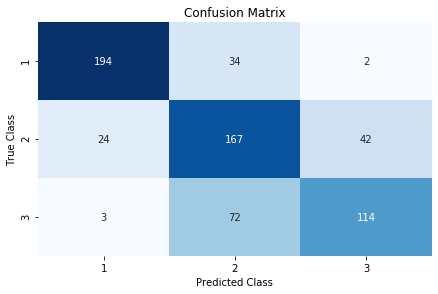

              precision    recall  f1-score   support

           1       0.88      0.84      0.86       230
           2       0.61      0.72      0.66       233
           3       0.72      0.60      0.66       189

    accuracy                           0.73       652
   macro avg       0.74      0.72      0.73       652
weighted avg       0.74      0.73      0.73       652

 NB: 0.633834 (0.022509)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


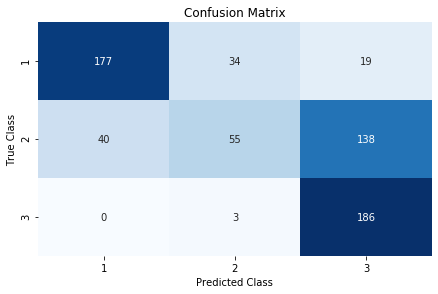

              precision    recall  f1-score   support

           1       0.82      0.77      0.79       230
           2       0.60      0.24      0.34       233
           3       0.54      0.98      0.70       189

    accuracy                           0.64       652
   macro avg       0.65      0.66      0.61       652
weighted avg       0.66      0.64      0.60       652



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


 SVM: 0.453597 (0.026419)


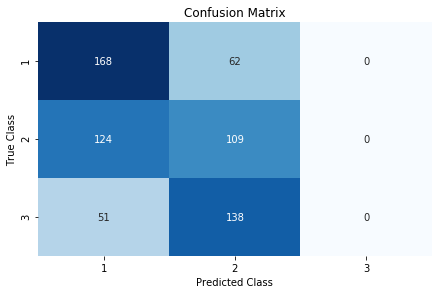

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.49      0.73      0.59       230
           2       0.35      0.47      0.40       233
           3       0.00      0.00      0.00       189

    accuracy                           0.42       652
   macro avg       0.28      0.40      0.33       652
weighted avg       0.30      0.42      0.35       652



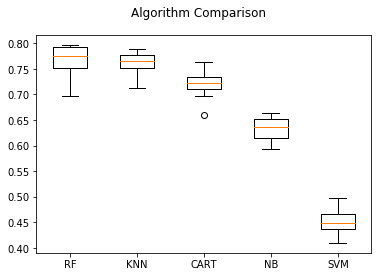

In [0]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import seaborn as sns
from sklearn.metrics import classification_report

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
Predict = []
matrix = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print('\033[1m \033[94m' + msg)
	
	model.fit(X_train, y_train)
	Predict.append((name, model.predict(X_test)))
	matrix.append((name, confusion_matrix(y_test, np.array(Predict)[:,1][names.index(name)])))
	class_names = ['1', '2','3']
	dataframe = pd.DataFrame(np.array(matrix[names.index(name)])[1], index=class_names, columns=class_names)
	sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt = 'g')
	plt.title("Confusion Matrix"), plt.tight_layout()
	plt.ylabel("True Class"), plt.xlabel("Predicted Class")
	plt.show()

	print(classification_report(y_test, np.array(Predict)[:,1][names.index(name)], target_names=class_names))


	
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()